In [1]:
# Install required packages
!pip install -q transformers datasets torch torchvision
!pip install -q grad-cam opencv-python-headless
!pip install -q matplotlib seaborn scikit-learn
!pip install -q pillow numpy pandas
!pip install -q safetensors

print("✅ All packages installed successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
✅ All packages installed successfully!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

print("✅ Google Drive mounted successfully!")

Mounted at /content/drive
✅ Google Drive mounted successfully!


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

# Transformers
from transformers import (
    ConvNextV2ForImageClassification,
    AutoImageProcessor,
    ConvNextV2Config
)

# GRAD-CAM
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, LayerCAM, GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

print("✅ All libraries imported successfully!")

Using device: cuda
✅ All libraries imported successfully!


In [4]:
# ========== CONFIGURATION ==========
# Update this path to point to your model checkpoint folder in Google Drive
MODEL_PATH = "/content/drive/MyDrive/Projects/6_Project Phoenix_Cervical Cancer Cell Classification/Explainability Worflows/Simple Explanability/convnextv2_cervical_v0.1/content/convnextv2_cervical/checkpoint-1015"

# Class names (in the same order as your model's id2label)
CLASS_NAMES = [
    'im_Dyskeratotic',
    'im_Koilocytotic',
    'im_Metaplastic',
    'im_Parabasal',
    'im_Superficial-Intermediate'
]

# Display names (cleaner for visualization)
DISPLAY_NAMES = [
    'Dyskeratotic',
    'Koilocytotic',
    'Metaplastic',
    'Parabasal',
    'Superficial-Intermediate'
]

# Image preprocessing parameters
IMG_SIZE = 224
NORMALIZATION_MEAN = [0.485, 0.456, 0.406]
NORMALIZATION_STD = [0.229, 0.224, 0.225]

# Create id2label and label2id mappings
id2label = {i: name for i, name in enumerate(CLASS_NAMES)}
label2id = {name: i for i, name in enumerate(CLASS_NAMES)}

print("Configuration set up successfully!")
print(f"Model path: {MODEL_PATH}")
print(f"Number of classes: {len(CLASS_NAMES)}")
print(f"Device: {device}")

Configuration set up successfully!
Model path: /content/drive/MyDrive/Projects/6_Project Phoenix_Cervical Cancer Cell Classification/Explainability Worflows/Simple Explanability/convnextv2_cervical_v0.1/content/convnextv2_cervical/checkpoint-1015
Number of classes: 5
Device: cuda


In [5]:
def load_model_from_checkpoint(checkpoint_path, device):
    """
    Load ConvNeXtV2 model from checkpoint with all necessary files.

    Expected files in checkpoint_path:
    - config.json
    - model.safetensors
    - preprocessor_config.json
    - optimizer.pt (optional)
    - scheduler.pt (optional)
    - trainer_state.json (optional)
    - training_args.bin (optional)
    - rng_state.pth (optional)
    - scaler.pt (optional)
    """
    print("\n" + "="*60)
    print("LOADING MODEL FROM CHECKPOINT")
    print("="*60)

    # Check if checkpoint path exists
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint path not found: {checkpoint_path}")

    # List files in checkpoint directory
    checkpoint_files = os.listdir(checkpoint_path)
    print(f"\nFiles found in checkpoint directory:")
    for file in sorted(checkpoint_files):
        file_size = os.path.getsize(os.path.join(checkpoint_path, file)) / (1024 * 1024)
        print(f"  - {file} ({file_size:.2f} MB)")

    # Load the model
    print("\n📥 Loading model...")
    try:
        model = ConvNextV2ForImageClassification.from_pretrained(
            checkpoint_path,
            local_files_only=True
        )
        model.to(device)
        model.eval()
        print("✅ Model loaded successfully!")
    except Exception as e:
        print(f"❌ Error loading model: {str(e)}")
        raise

    # Load the image processor
    print("\n📥 Loading image processor...")
    try:
        processor = AutoImageProcessor.from_pretrained(
            checkpoint_path,
            local_files_only=True
        )
        print("✅ Image processor loaded successfully!")
    except Exception as e:
        print(f"❌ Error loading processor: {str(e)}")
        raise

    # Print model information
    print("\n" + "="*60)
    print("MODEL INFORMATION")
    print("="*60)
    print(f"Model type: {model.config.model_type}")
    print(f"Number of labels: {model.config.num_labels}")
    print(f"Hidden sizes: {model.config.hidden_sizes}")
    print(f"Image size: {model.config.image_size}")

    if hasattr(model.config, 'id2label'):
        print(f"\nClass labels:")
        for idx, label in model.config.id2label.items():
            print(f"  {idx}: {label}")

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    print("="*60)

    return model, processor

# Load the model
model, processor = load_model_from_checkpoint(MODEL_PATH, device)


LOADING MODEL FROM CHECKPOINT

Files found in checkpoint directory:
  - config.json (0.00 MB)
  - model.safetensors (106.34 MB)
  - optimizer.pt (212.80 MB)
  - preprocessor_config.json (0.00 MB)
  - rng_state.pth (0.01 MB)
  - scaler.pt (0.00 MB)
  - scheduler.pt (0.00 MB)
  - trainer_state.json (0.01 MB)
  - training_args.bin (0.01 MB)

📥 Loading model...
✅ Model loaded successfully!

📥 Loading image processor...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✅ Image processor loaded successfully!

MODEL INFORMATION
Model type: convnextv2
Number of labels: 5
Hidden sizes: [96, 192, 384, 768]
Image size: 224

Class labels:
  0: im_Dyskeratotic
  1: im_Koilocytotic
  2: im_Metaplastic
  3: im_Parabasal
  4: im_Superficial-Intermediate

Total parameters: 27,870,341
Trainable parameters: 27,870,341


In [59]:
def load_and_preprocess_image(image_path, processor, return_original=True):
    """
    Load and preprocess an image for model input.

    Args:
        image_path: Path to the image file
        processor: Image processor from the model
        return_original: Whether to return the original image for visualization

    Returns:
        Tuple of (preprocessed_tensor, original_image_array)
    """
    # Load image
    image = Image.open(image_path).convert('RGB')

    # Store original for visualization
    original_image = np.array(image)

    # Preprocess using the model's processor
    inputs = processor(images=image, return_tensors="pt")
    pixel_values = inputs['pixel_values'].to(device)

    if return_original:
        return pixel_values, original_image
    return pixel_values


def denormalize_image(tensor, mean=NORMALIZATION_MEAN, std=NORMALIZATION_STD):
    """
    Denormalize a tensor image for visualization.

    Args:
        tensor: Normalized image tensor (C, H, W)
        mean: Normalization mean
        std: Normalization standard deviation

    Returns:
        Denormalized image as numpy array
    """
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)

    # Denormalize
    denorm = tensor.cpu() * std + mean
    denorm = denorm.clamp(0, 1)

    # Convert to numpy and transpose to (H, W, C)
    return denorm.numpy().transpose(1, 2, 0)


def resize_image_for_cam(image, target_size=224):
    """
    Resize image to match the CAM size.

    Args:
        image: Input image as numpy array
        target_size: Target size for resizing

    Returns:
        Resized image
    """
    # This function is no longer directly used for creating rgb_image for show_cam_on_image
    # but can be kept for other purposes if needed.
    return cv2.resize(image, (target_size, target_size))


print("✅ Image preprocessing functions defined!")

✅ Image preprocessing functions defined!


In [60]:
def predict_image(model, image_path, processor, display_names=DISPLAY_NAMES, top_k=3):
    """
    Make prediction on an image and return results.

    Args:
        model: Trained ConvNeXt model
        image_path: Path to the image
        processor: Image processor
        display_names: List of class display names
        top_k: Number of top predictions to return

    Returns:
        Dictionary with prediction results
    """
    # Load and preprocess image
    pixel_values, original_image = load_and_preprocess_image(image_path, processor)

    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(pixel_values)
        logits = outputs.logits

    # Get probabilities
    probabilities = F.softmax(logits, dim=-1)[0]

    # Get top-k predictions
    top_probs, top_indices = torch.topk(probabilities, k=min(top_k, len(display_names)))

    # Get predicted class
    predicted_class_idx = logits.argmax(-1).item()
    predicted_class_name = display_names[predicted_class_idx]
    predicted_confidence = probabilities[predicted_class_idx].item()

    # Prepare results
    results = {
        'predicted_class': predicted_class_name,
        'predicted_idx': predicted_class_idx,
        'confidence': predicted_confidence,
        'probabilities': probabilities.cpu().numpy(),
        'top_k_classes': [display_names[idx] for idx in top_indices],
        'top_k_probs': top_probs.cpu().numpy(),
        'logits': logits.cpu().numpy()[0],
        'original_image': original_image
    }

    return results


def display_prediction_results(results, figsize=(12, 6)):
    """
    Display prediction results with visualization.

    Args:
        results: Dictionary from predict_image function
        figsize: Figure size
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Display image
    axes[0].imshow(results['original_image'])
    axes[0].set_title(f"Predicted: {results['predicted_class']}\nConfidence: {results['confidence']:.2%}",
                     fontsize=12, fontweight='bold')
    axes[0].axis('off')

    # Display probability distribution
    probabilities = results['probabilities']
    class_names = DISPLAY_NAMES

    colors = ['#2ecc71' if i == results['predicted_idx'] else '#3498db'
              for i in range(len(class_names))]

    axes[1].barh(class_names, probabilities * 100, color=colors)
    axes[1].set_xlabel('Probability (%)', fontsize=11)
    axes[1].set_title('Class Probabilities', fontsize=12, fontweight='bold')
    axes[1].set_xlim(0, 100)

    # Add percentage labels
    for i, prob in enumerate(probabilities):
        axes[1].text(prob * 100 + 1, i, f'{prob*100:.1f}%',
                    va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

    # Print detailed results
    print("\n" + "="*60)
    print("PREDICTION RESULTS")
    print("="*60)
    print(f"Predicted Class: {results['predicted_class']}")
    print(f"Confidence: {results['confidence']:.2%}")
    print(f"\nTop {len(results['top_k_classes'])} Predictions:")
    for i, (cls, prob) in enumerate(zip(results['top_k_classes'], results['top_k_probs'])):
        print(f"  {i+1}. {cls}: {prob:.2%}")
    print("="*60)


print("✅ Inference functions defined!")

✅ Inference functions defined!


In [61]:
class ConvNeXtGradCAMWrapper(nn.Module):
    """
    Wrapper for ConvNeXtV2ForImageClassification to make it compatible with GRAD-CAM.
    """
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        # Get the logits from the model
        outputs = self.model(pixel_values=x)
        return outputs.logits


def get_target_layers(model):
    """
    Get the target layers for GRAD-CAM from ConvNeXt model.

    For ConvNeXtV2, we typically use the last convolutional layer
    from the last stage before the classification head.

    Args:
        model: ConvNeXtV2ForImageClassification model

    Returns:
        List of target layers for GRAD-CAM
    """
    # ConvNeXtV2 structure: convnextv2.encoder.stages[-1]
    # We want the last layer of the last stage
    target_layers = [model.convnextv2.encoder.stages[-1].layers[-1]]
    return target_layers


def apply_gradcam(model, image_path, processor, target_class=None,
                 colormap=cv2.COLORMAP_JET): # Removed use_cuda from signature
    """
    Apply GRAD-CAM to visualize model attention.

    Args:
        model: Trained ConvNeXt model
        image_path: Path to the image
        processor: Image processor
        target_class: Target class index (None for predicted class)
        colormap: OpenCV colormap for visualization

    Returns:
        Dictionary with GRAD-CAM visualization and metadata
    """
    # Wrap the model
    wrapped_model = ConvNeXtGradCAMWrapper(model)

    # Get target layers
    target_layers = get_target_layers(model)

    # Initialize GRAD-CAM
    cam = GradCAM(model=wrapped_model, target_layers=target_layers)

    # Load and preprocess image
    pixel_values, original_image = load_and_preprocess_image(image_path, processor)

    # Get prediction
    model.eval()
    with torch.no_grad():
        outputs = model(pixel_values)
        logits = outputs.logits
        predicted_class = logits.argmax(-1).item()
        probabilities = F.softmax(logits, dim=-1)[0]

    # Use predicted class if target not specified
    if target_class is None:
        target_class = predicted_class

    # Create target for GRAD-CAM
    targets = [ClassifierOutputTarget(target_class)]

    # Generate GRAD-CAM
    grayscale_cam = cam(input_tensor=pixel_values, targets=targets)
    grayscale_cam = grayscale_cam[0, :] # This is (H, W)

    # Ensure rgb_image matches spatial dimensions of grayscale_cam for overlay
    cam_h, cam_w = grayscale_cam.shape
    rgb_image_for_overlay = cv2.resize(original_image, (cam_w, cam_h)).astype(np.float32) / 255.0

    print(f"DEBUG: original_image.shape: {original_image.shape}")
    print(f"DEBUG: grayscale_cam.shape: {grayscale_cam.shape}")
    print(f"DEBUG: rgb_image_for_overlay.shape: {rgb_image_for_overlay.shape}")

    # Create visualization
    visualization = show_cam_on_image(rgb_image_for_overlay, grayscale_cam, use_rgb=True,
                                     colormap=colormap)

    return {
        'original_image': original_image,
        'grayscale_cam': grayscale_cam,
        'visualization': visualization,
        'predicted_class': predicted_class,
        'target_class': target_class,
        'confidence': probabilities[predicted_class].item(),
        'all_probabilities': probabilities.cpu().numpy()
    }


def display_gradcam_results(results, display_names=DISPLAY_NAMES, figsize=(18, 6)):
    """
    Display GRAD-CAM results in a comprehensive visualization.

    Args:
        results: Dictionary from apply_gradcam function
        display_names: List of class display names
        figsize: Figure size
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # Original image
    axes[0].imshow(results['original_image'])
    axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # Heatmap only
    axes[1].imshow(results['grayscale_cam'], cmap='jet')
    axes[1].set_title('GRAD-CAM Heatmap', fontsize=14, fontweight='bold')
    axes[1].axis('off')

    # Overlay
    axes[2].imshow(results['visualization'])
    predicted_name = display_names[results['predicted_class']]
    target_name = display_names[results['target_class']]

    title = f"GRAD-CAM Overlay\nPredicted: {predicted_name} ({results['confidence']:.2%})"
    if results['predicted_class'] != results['target_class']:
        title += f"\nTarget: {target_name}"

    axes[2].set_title(title, fontsize=14, fontweight='bold')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    # Print information
    print("\n" + "="*60)
    print("GRAD-CAM ANALYSIS")
    print("="*60)
    print(f"Predicted Class: {predicted_name}")
    print(f"Confidence: {results['confidence']:.2%}")
    print(f"Target Class for CAM: {target_name}")
    print("\nHeatmap Interpretation:")
    print("  🔴 Red regions: High importance for classification")
    print("  🔵 Blue regions: Low importance for classification")
    print("="*60)


print("✅ GRAD-CAM functions defined!")

✅ GRAD-CAM functions defined!


In [62]:
def apply_layercam(model, image_path, processor, target_class=None,
                  colormap=cv2.COLORMAP_JET): # Removed use_cuda from signature
    """
    Apply Layer-CAM to visualize model attention.

    Args:
        model: Trained ConvNeXt model
        image_path: Path to the image
        processor: Image processor
        target_class: Target class index (None for predicted class)
        colormap: OpenCV colormap for visualization

    Returns:
        Dictionary with Layer-CAM visualization and metadata
    """
    # Wrap the model
    wrapped_model = ConvNeXtGradCAMWrapper(model)

    # Get target layers
    target_layers = get_target_layers(model)

    # Initialize Layer-CAM
    cam = LayerCAM(model=wrapped_model, target_layers=target_layers)

    # Load and preprocess image
    pixel_values, original_image = load_and_preprocess_image(image_path, processor)

    # Get prediction
    model.eval()
    with torch.no_grad():
        outputs = model(pixel_values)
        logits = outputs.logits
        predicted_class = logits.argmax(-1).item()
        probabilities = F.softmax(logits, dim=-1)[0]

    # Use predicted class if target not specified
    if target_class is None:
        target_class = predicted_class

    # Create target for Layer-CAM
    targets = [ClassifierOutputTarget(target_class)]

    # Generate Layer-CAM
    grayscale_cam = cam(input_tensor=pixel_values, targets=targets)
    grayscale_cam = grayscale_cam[0, :] # This is (H, W)

    # Ensure rgb_image matches spatial dimensions of grayscale_cam for overlay
    cam_h, cam_w = grayscale_cam.shape
    rgb_image_for_overlay = cv2.resize(original_image, (cam_w, cam_h)).astype(np.float32) / 255.0

    print(f"DEBUG: original_image.shape: {original_image.shape}")
    print(f"DEBUG: grayscale_cam.shape: {grayscale_cam.shape}")
    print(f"DEBUG: rgb_image_for_overlay.shape: {rgb_image_for_overlay.shape}")

    # Create visualization
    visualization = show_cam_on_image(rgb_image_for_overlay, grayscale_cam, use_rgb=True,
                                     colormap=colormap)

    return {
        'original_image': original_image,
        'grayscale_cam': grayscale_cam,
        'visualization': visualization,
        'predicted_class': predicted_class,
        'target_class': target_class,
        'confidence': probabilities[predicted_class].item(),
        'all_probabilities': probabilities.cpu().numpy()
    }


def display_layercam_results(results, display_names=DISPLAY_NAMES, figsize=(18, 6)):
    """
    Display Layer-CAM results in a comprehensive visualization.

    Args:
        results: Dictionary from apply_layercam function
        display_names: List of class display names
        figsize: Figure size
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # Original image
    axes[0].imshow(results['original_image'])
    axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # Heatmap only
    axes[1].imshow(results['grayscale_cam'], cmap='jet')
    axes[1].set_title('Layer-CAM Heatmap', fontsize=14, fontweight='bold')
    axes[1].axis('off')

    # Overlay
    axes[2].imshow(results['visualization'])
    predicted_name = display_names[results['predicted_class']]
    target_name = display_names[results['target_class']]

    title = f"Layer-CAM Overlay\nPredicted: {predicted_name} ({results['confidence']:.2%})"
    if results['predicted_class'] != results['target_class']:
        title += f"\nTarget: {target_name}"

    axes[2].set_title(title, fontsize=14, fontweight='bold')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    print("\n" + "="*60)
    print("LAYER-CAM ANALYSIS")
    print("="*60)
    print(f"Predicted Class: {predicted_name}")
    print(f"Confidence: {results['confidence']:.2%}")
    print(f"Target Class for CAM: {target_name}")
    print("="*60)


print("✅ Layer-CAM functions defined!")

✅ Layer-CAM functions defined!


In [63]:
def apply_gradcam_plusplus(model, image_path, processor, target_class=None,
                          colormap=cv2.COLORMAP_JET): # Removed use_cuda from signature
    """
    Apply GRAD-CAM++ to visualize model attention.

    Args:
        model: Trained ConvNeXt model
        image_path: Path to the image
        processor: Image processor
        target_class: Target class index (None for predicted class)
        colormap: OpenCV colormap for visualization

    Returns:
        Dictionary with GRAD-CAM++ visualization and metadata
    """
    # Wrap the model
    wrapped_model = ConvNeXtGradCAMWrapper(model)

    # Get target layers
    target_layers = get_target_layers(model)

    # Initialize GRAD-CAM++
    cam = GradCAMPlusPlus(model=wrapped_model, target_layers=target_layers)

    # Load and preprocess image
    pixel_values, original_image = load_and_preprocess_image(image_path, processor)

    # Get prediction
    model.eval()
    with torch.no_grad():
        outputs = model(pixel_values)
        logits = outputs.logits
        predicted_class = logits.argmax(-1).item()
        probabilities = F.softmax(logits, dim=-1)[0]

    # Use predicted class if target not specified
    if target_class is None:
        target_class = predicted_class

    # Create target for GRAD-CAM++
    targets = [ClassifierOutputTarget(target_class)]

    # Generate GRAD-CAM++
    grayscale_cam = cam(input_tensor=pixel_values, targets=targets)
    grayscale_cam = grayscale_cam[0, :] # This is (H, W)

    # Ensure rgb_image matches spatial dimensions of grayscale_cam for overlay
    cam_h, cam_w = grayscale_cam.shape
    rgb_image_for_overlay = cv2.resize(original_image, (cam_w, cam_h)).astype(np.float32) / 255.0

    print(f"DEBUG: original_image.shape: {original_image.shape}")
    print(f"DEBUG: grayscale_cam.shape: {grayscale_cam.shape}")
    print(f"DEBUG: rgb_image_for_overlay.shape: {rgb_image_for_overlay.shape}")

    # Create visualization
    visualization = show_cam_on_image(rgb_image_for_overlay, grayscale_cam, use_rgb=True,
                                     colormap=colormap)

    return {
        'original_image': original_image,
        'grayscale_cam': grayscale_cam,
        'visualization': visualization,
        'predicted_class': predicted_class,
        'target_class': target_class,
        'confidence': probabilities[predicted_class].item(),
        'all_probabilities': probabilities.cpu().numpy()
    }


print("✅ GRAD-CAM++ functions defined!")

✅ GRAD-CAM++ functions defined!


In [64]:
def compare_explainability_methods(model, image_path, processor, target_class=None,
                                  display_names=DISPLAY_NAMES, figsize=(20, 12)):
    """
    Compare GRAD-CAM, GRAD-CAM++, and Layer-CAM side-by-side.

    Args:
        model: Trained ConvNeXt model
        image_path: Path to the image
        processor: Image processor
        target_class: Target class index (None for predicted class)
        display_names: List of class display names
        figsize: Figure size
    """
    print("Generating visualizations...")

    # Apply all methods
    gradcam_results = apply_gradcam(model, image_path, processor, target_class)
    gradcam_pp_results = apply_gradcam_plusplus(model, image_path, processor, target_class)
    layercam_results = apply_layercam(model, image_path, processor, target_class)

    # Create comprehensive visualization
    fig, axes = plt.subplots(3, 3, figsize=figsize)

    methods = ['GRAD-CAM', 'GRAD-CAM++', 'Layer-CAM']
    results_list = [gradcam_results, gradcam_pp_results, layercam_results]

    for row, (method_name, results) in enumerate(zip(methods, results_list)):
        # Original image
        axes[row, 0].imshow(results['original_image'])
        axes[row, 0].set_title(f'{method_name}\nOriginal Image', fontsize=12, fontweight='bold')
        axes[row, 0].axis('off')

        # Heatmap
        axes[row, 1].imshow(results['grayscale_cam'], cmap='jet')
        axes[row, 1].set_title(f'{method_name}\nHeatmap', fontsize=12, fontweight='bold')
        axes[row, 1].axis('off')

        # Overlay
        axes[row, 2].imshow(results['visualization'])
        predicted_name = display_names[results['predicted_class']]
        axes[row, 2].set_title(f'{method_name}\nOverlay: {predicted_name}',
                              fontsize=12, fontweight='bold')
        axes[row, 2].axis('off')

    plt.suptitle(f"Comparison of Explainability Methods\nPredicted: {predicted_name} (Confidence: {results['confidence']:.2%})",
                fontsize=16, fontweight='bold', y=0.98)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Print comparison summary
    print("\n" + "="*80)
    print("EXPLAINABILITY METHODS COMPARISON")
    print("="*80)
    print(f"Image: {os.path.basename(image_path)}")
    print(f"Predicted Class: {predicted_name}")
    print(f"Confidence: {gradcam_results['confidence']:.2%}")
    print("\nMethod Characteristics:")
    print("  • GRAD-CAM: Classic gradient-based attention (good general performance)")
    print("  • GRAD-CAM++: Improved localization for multiple instances")
    print("  • Layer-CAM: Fine-grained layer-wise attention")
    print("="*80)


print("✅ Comparative visualization functions defined!")

✅ Comparative visualization functions defined!


In [65]:
def visualize_all_classes(model, image_path, processor, display_names=DISPLAY_NAMES,
                         method='gradcam', figsize=(20, 8)):
    """
    Visualize GRAD-CAM for all classes to understand what the model looks for
    when predicting each class.

    Args:
        model: Trained ConvNeXt model
        image_path: Path to the image
        processor: Image processor
        display_names: List of class display names
        method: Which CAM method to use ('gradcam', 'gradcam++', 'layercam')
        figsize: Figure size
    """
    # Select the appropriate method
    if method == 'gradcam':
        apply_func = apply_gradcam
        title_prefix = "GRAD-CAM"
    elif method == 'gradcam++':
        apply_func = apply_gradcam_plusplus
        title_prefix = "GRAD-CAM++"
    else:
        apply_func = apply_layercam
        title_prefix = "Layer-CAM"

    print(f"Generating {title_prefix} for all classes...")

    # Get prediction first
    pixel_values, original_image = load_and_preprocess_image(image_path, processor)
    model.eval()
    with torch.no_grad():
        outputs = model(pixel_values)
        logits = outputs.logits
        predicted_class = logits.argmax(-1).item()
        probabilities = F.softmax(logits, dim=-1)[0]

    # Create figure
    num_classes = len(display_names)
    fig, axes = plt.subplots(2, num_classes, figsize=figsize)

    if num_classes == 1:
        axes = axes.reshape(2, 1)

    # Generate CAM for each class
    for class_idx in range(num_classes):
        results = apply_func(model, image_path, processor, target_class=class_idx)

        # Heatmap
        axes[0, class_idx].imshow(results['grayscale_cam'], cmap='jet')
        is_predicted = (class_idx == predicted_class)
        border_color = 'green' if is_predicted else 'gray'

        title = f"{display_names[class_idx]}\n{probabilities[class_idx]:.1%}"
        if is_predicted:
            title = "✓ " + title

        axes[0, class_idx].set_title(title, fontsize=11,
                                     fontweight='bold' if is_predicted else 'normal',
                                     color='green' if is_predicted else 'black')
        axes[0, class_idx].axis('off')

        # Add border to predicted class
        if is_predicted:
            for spine in axes[0, class_idx].spines.values():
                spine.set_edgecolor(border_color)
                spine.set_linewidth(3)

        # Overlay
        axes[1, class_idx].imshow(results['visualization'])
        axes[1, class_idx].axis('off')

        if is_predicted:
            for spine in axes[1, class_idx].spines.values():
                spine.set_edgecolor(border_color)
                spine.set_linewidth(3)

    plt.suptitle(f"{title_prefix} Analysis for All Classes\nPredicted: {display_names[predicted_class]} ({probabilities[predicted_class]:.2%})",
                fontsize=16, fontweight='bold', y=0.98)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    print("\n" + "="*80)
    print("MULTI-CLASS EXPLAINABILITY ANALYSIS")
    print("="*80)
    print(f"Predicted Class: {display_names[predicted_class]} ({probabilities[predicted_class]:.2%})")
    print("\nClass Probabilities:")
    for idx, (name, prob) in enumerate(zip(display_names, probabilities)):
        marker = "✓" if idx == predicted_class else " "
        print(f"  {marker} {name}: {prob:.2%}")
    print("\nInterpretation:")
    print("  The visualizations show which regions the model focuses on for each class.")
    print("  Green border indicates the predicted class.")
    print("="*80)


print("✅ Multi-class explainability functions defined!")

✅ Multi-class explainability functions defined!


In [75]:
# Upload an image from your computer
from google.colab import files
import io

print("Please upload a cervical cell image (.bmp, .png, .jpg):")
uploaded = files.upload()

if uploaded:
    # Get the first uploaded file
    image_name = list(uploaded.keys())[0]
    image_path = f"/content/{image_name}"

    # Save the uploaded file
    with open(image_path, 'wb') as f:
        f.write(uploaded[image_name])

    print(f"\n✅ Image uploaded: {image_name}")
    print(f"Image saved to: {image_path}")
else:
    # Use a default path if no file uploaded
    image_path = "/content/drive/MyDrive/Projects/6_Project Phoenix_Cervical Cancer Cell Classification/Preprocessed Datasets/Augmented Datasets/Augmented Dataset - Limited Enhancement/im_Koilocytotic/NLM_CLAHE/001_01_processed.bmp"
    print(f"Using default image path: {image_path}")

Please upload a cervical cell image (.bmp, .png, .jpg):


Saving 002_04_processed.bmp to 002_04_processed.bmp

✅ Image uploaded: 002_04_processed.bmp
Image saved to: /content/002_04_processed.bmp


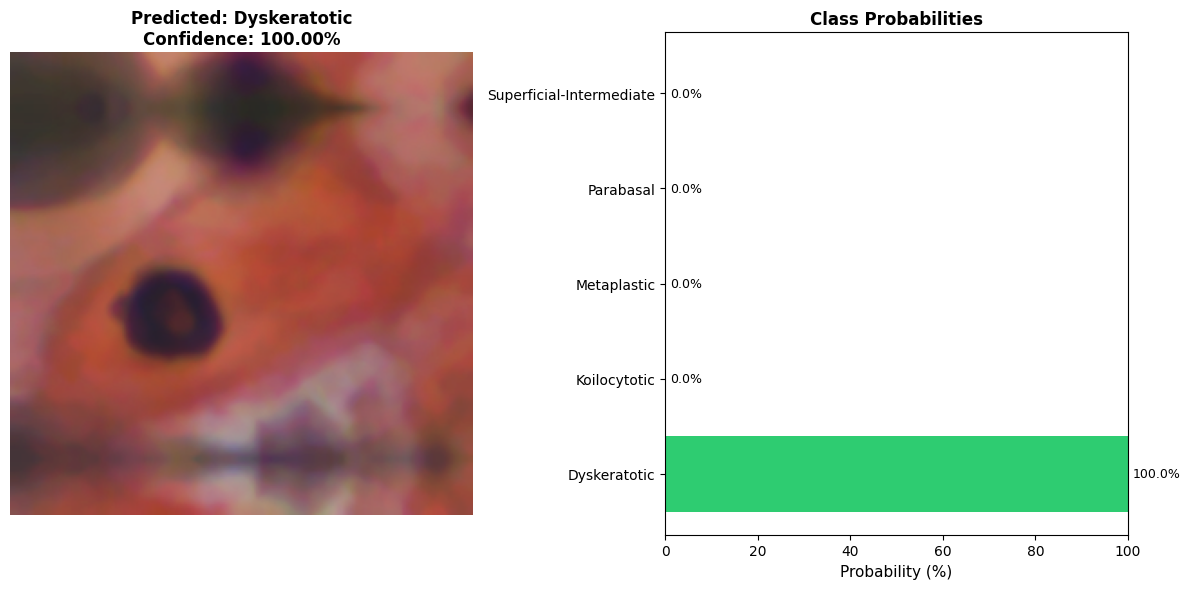


PREDICTION RESULTS
Predicted Class: Dyskeratotic
Confidence: 100.00%

Top 3 Predictions:
  1. Dyskeratotic: 100.00%
  2. Koilocytotic: 0.00%
  3. Parabasal: 0.00%


In [76]:
# Make prediction and display results
results = predict_image(model, image_path, processor, display_names=DISPLAY_NAMES)
display_prediction_results(results)

DEBUG: original_image.shape: (256, 256, 3)
DEBUG: grayscale_cam.shape: (384, 384)
DEBUG: rgb_image_for_overlay.shape: (384, 384, 3)


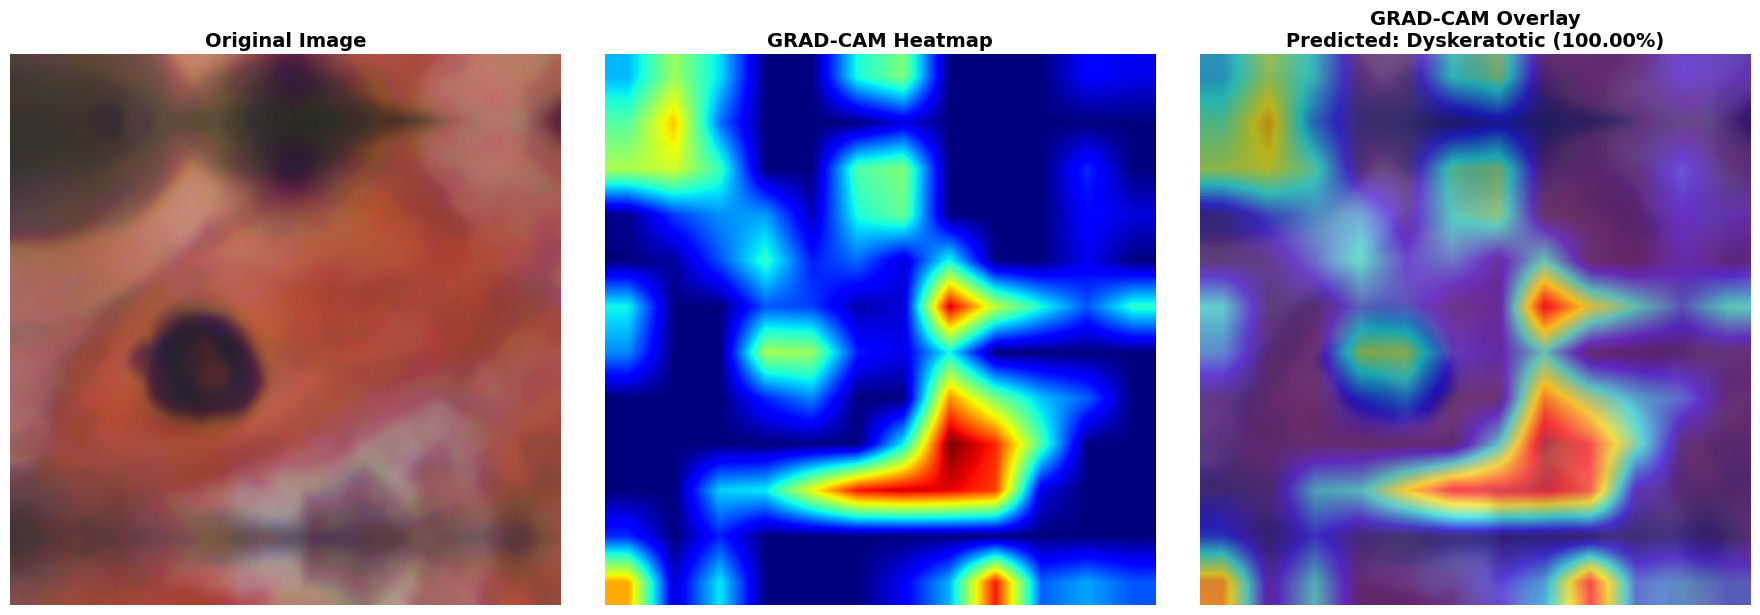


GRAD-CAM ANALYSIS
Predicted Class: Dyskeratotic
Confidence: 100.00%
Target Class for CAM: Dyskeratotic

Heatmap Interpretation:
  🔴 Red regions: High importance for classification
  🔵 Blue regions: Low importance for classification


In [77]:
# Apply GRAD-CAM
gradcam_results = apply_gradcam(model, image_path, processor)
display_gradcam_results(gradcam_results, display_names=DISPLAY_NAMES)

DEBUG: original_image.shape: (256, 256, 3)
DEBUG: grayscale_cam.shape: (384, 384)
DEBUG: rgb_image_for_overlay.shape: (384, 384, 3)


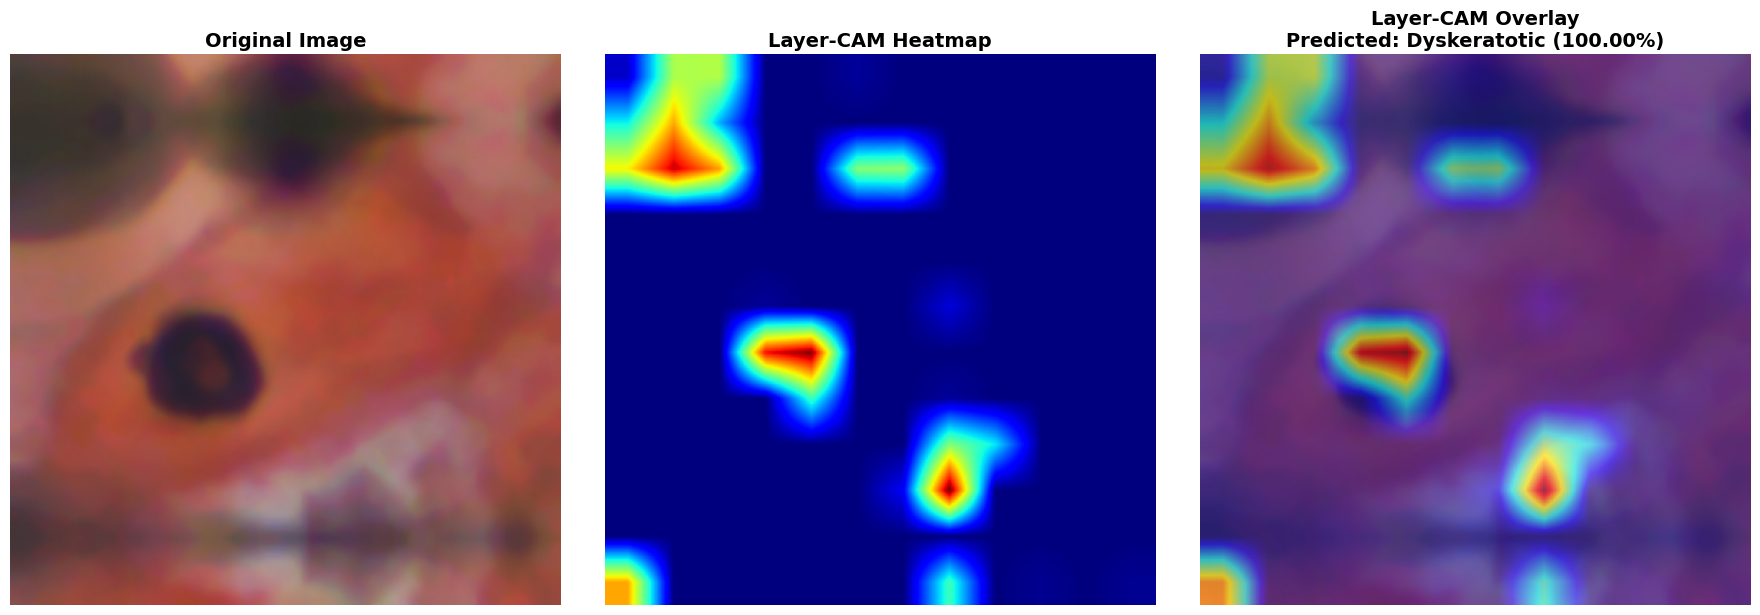


LAYER-CAM ANALYSIS
Predicted Class: Dyskeratotic
Confidence: 100.00%
Target Class for CAM: Dyskeratotic


In [78]:
# Apply Layer-CAM
layercam_results = apply_layercam(model, image_path, processor)
display_layercam_results(layercam_results, display_names=DISPLAY_NAMES)

Generating visualizations...
DEBUG: original_image.shape: (256, 256, 3)
DEBUG: grayscale_cam.shape: (384, 384)
DEBUG: rgb_image_for_overlay.shape: (384, 384, 3)
DEBUG: original_image.shape: (256, 256, 3)
DEBUG: grayscale_cam.shape: (384, 384)
DEBUG: rgb_image_for_overlay.shape: (384, 384, 3)
DEBUG: original_image.shape: (256, 256, 3)
DEBUG: grayscale_cam.shape: (384, 384)
DEBUG: rgb_image_for_overlay.shape: (384, 384, 3)


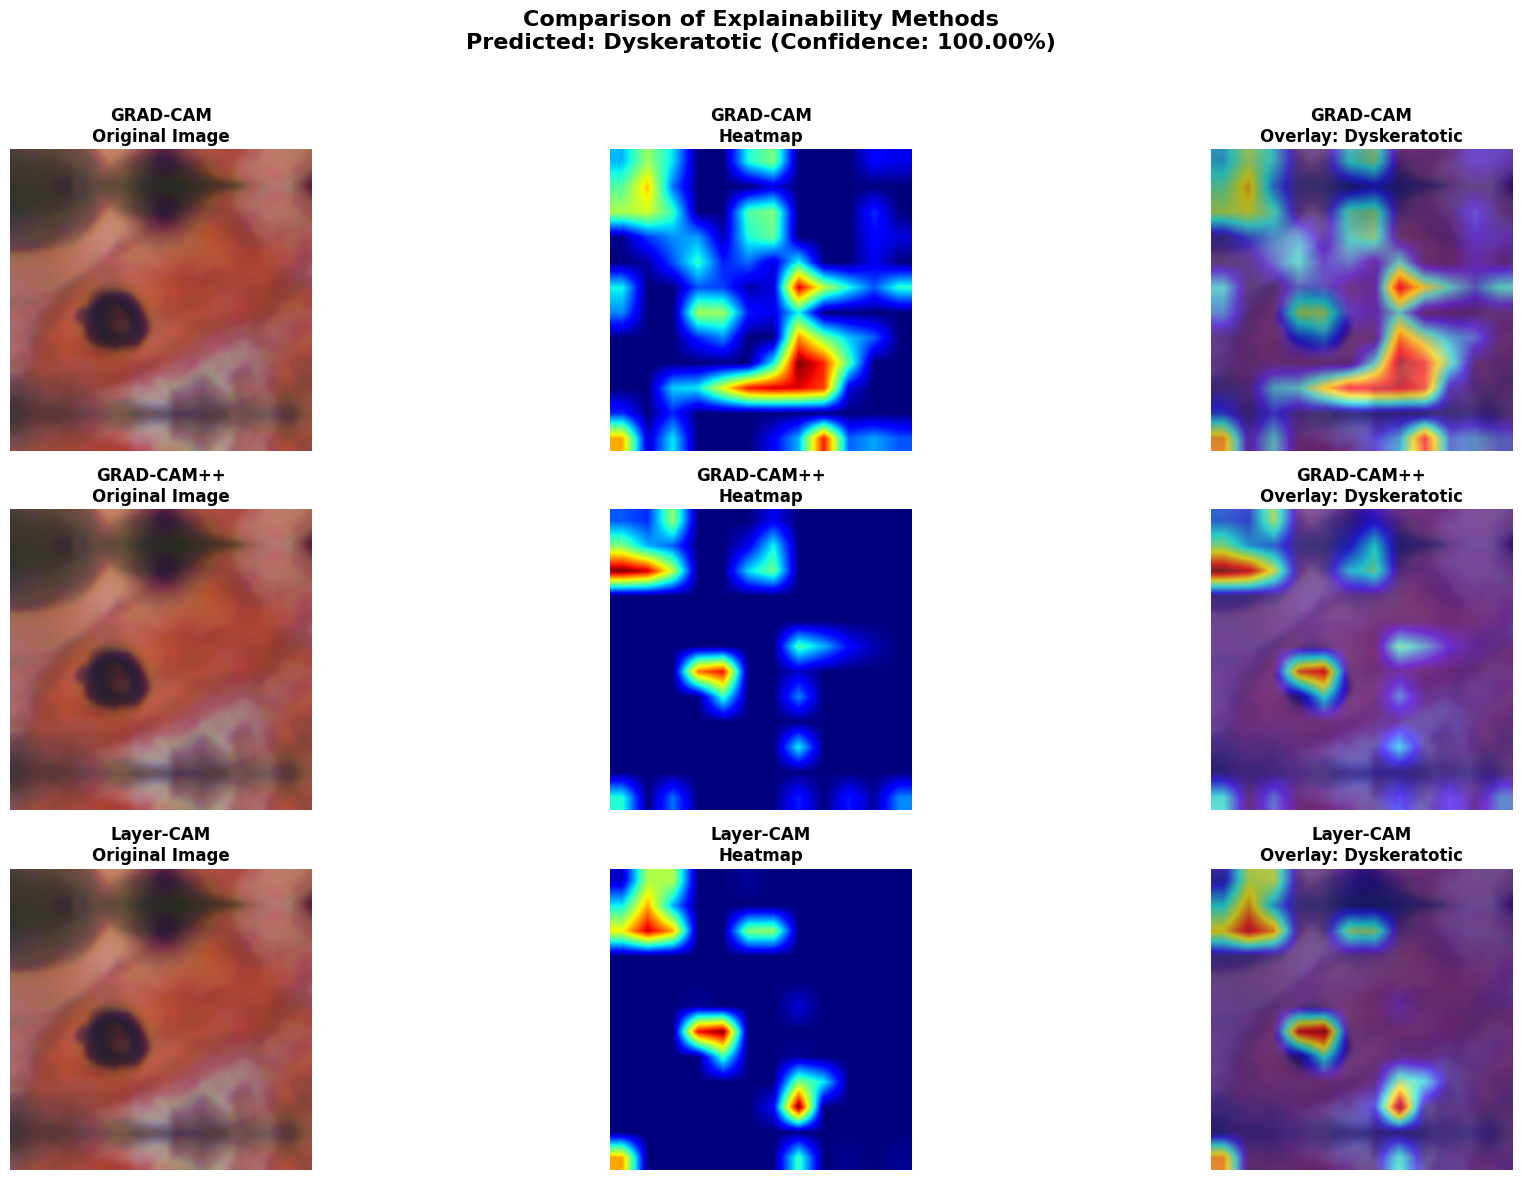


EXPLAINABILITY METHODS COMPARISON
Image: 002_04_processed.bmp
Predicted Class: Dyskeratotic
Confidence: 100.00%

Method Characteristics:
  • GRAD-CAM: Classic gradient-based attention (good general performance)
  • GRAD-CAM++: Improved localization for multiple instances
  • Layer-CAM: Fine-grained layer-wise attention


In [79]:
# Compare all explainability methods
compare_explainability_methods(model, image_path, processor, display_names=DISPLAY_NAMES)

Generating GRAD-CAM for all classes...
DEBUG: original_image.shape: (256, 256, 3)
DEBUG: grayscale_cam.shape: (384, 384)
DEBUG: rgb_image_for_overlay.shape: (384, 384, 3)
DEBUG: original_image.shape: (256, 256, 3)
DEBUG: grayscale_cam.shape: (384, 384)
DEBUG: rgb_image_for_overlay.shape: (384, 384, 3)
DEBUG: original_image.shape: (256, 256, 3)
DEBUG: grayscale_cam.shape: (384, 384)
DEBUG: rgb_image_for_overlay.shape: (384, 384, 3)
DEBUG: original_image.shape: (256, 256, 3)
DEBUG: grayscale_cam.shape: (384, 384)
DEBUG: rgb_image_for_overlay.shape: (384, 384, 3)
DEBUG: original_image.shape: (256, 256, 3)
DEBUG: grayscale_cam.shape: (384, 384)
DEBUG: rgb_image_for_overlay.shape: (384, 384, 3)


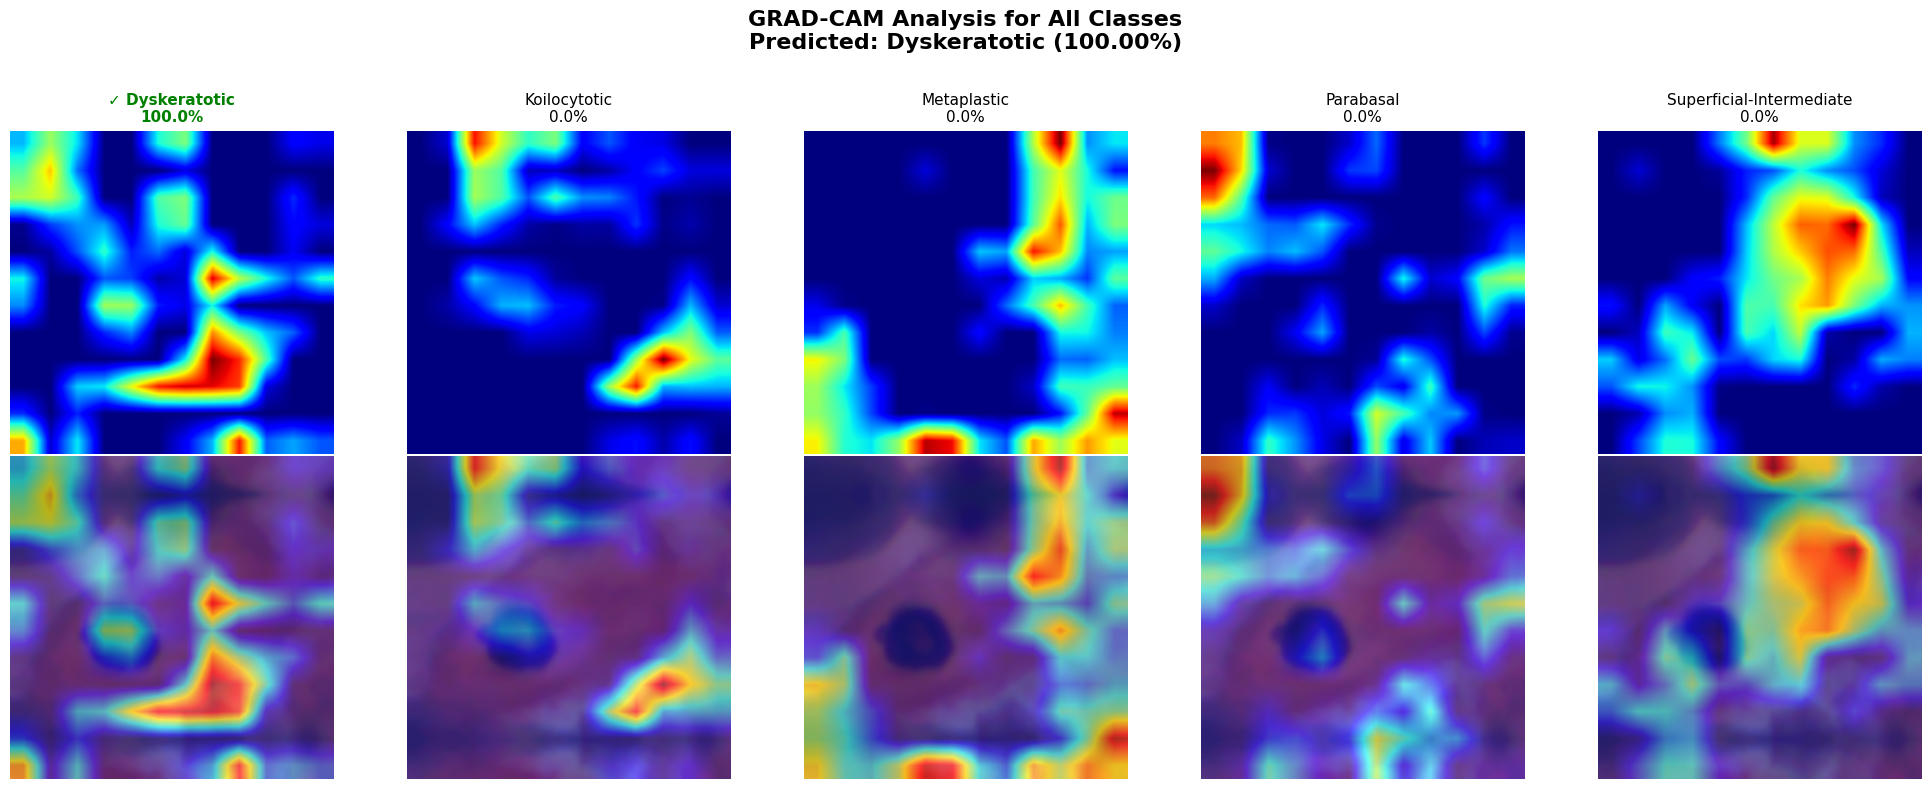


MULTI-CLASS EXPLAINABILITY ANALYSIS
Predicted Class: Dyskeratotic (100.00%)

Class Probabilities:
  ✓ Dyskeratotic: 100.00%
    Koilocytotic: 0.00%
    Metaplastic: 0.00%
    Parabasal: 0.00%
    Superficial-Intermediate: 0.00%

Interpretation:
  The visualizations show which regions the model focuses on for each class.
  Green border indicates the predicted class.


In [80]:
# Visualize what the model looks for in each class
visualize_all_classes(model, image_path, processor, display_names=DISPLAY_NAMES, method='gradcam')

In [81]:
def batch_analyze_images(model, image_dir, processor, display_names=DISPLAY_NAMES,
                        method='gradcam', max_images=10):
    """
    Analyze multiple images from a directory.

    Args:
        model: Trained ConvNeXt model
        image_dir: Directory containing images
        processor: Image processor
        display_names: List of class display names
        method: CAM method to use
        max_images: Maximum number of images to process
    """
    # Get image files
    image_extensions = ['.bmp', '.png', '.jpg', '.jpeg']
    image_files = []

    for ext in image_extensions:
        image_files.extend(Path(image_dir).glob(f"*{ext}"))
        image_files.extend(Path(image_dir).glob(f"*{ext.upper()}"))

    image_files = sorted(list(set(image_files)))[:max_images]

    if not image_files:
        print(f"No images found in {image_dir}")
        return

    print(f"Found {len(image_files)} images. Processing...\n")

    # Select method
    if method == 'gradcam':
        apply_func = apply_gradcam
    elif method == 'gradcam++':
        apply_func = apply_gradcam_plusplus
    else:
        apply_func = apply_layercam

    # Process each image
    results_summary = []

    for idx, image_path in enumerate(image_files):
        print(f"Processing {idx+1}/{len(image_files)}: {image_path.name}")

        try:
            # Get prediction
            pred_results = predict_image(model, str(image_path), processor, display_names)

            # Apply CAM
            cam_results = apply_func(model, str(image_path), processor)

            # Store results
            results_summary.append({
                'image_name': image_path.name,
                'predicted_class': pred_results['predicted_class'],
                'confidence': pred_results['confidence'],
                'top_3_classes': ', '.join(pred_results['top_k_classes'][:3])
            })

            # Display results
            print(f"  Predicted: {pred_results['predicted_class']} ({pred_results['confidence']:.2%})\n")

            # Visualize
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            fig.suptitle(f"{image_path.name}\n{pred_results['predicted_class']} ({pred_results['confidence']:.2%})",
                        fontsize=14, fontweight='bold')

            axes[0].imshow(cam_results['original_image'])
            axes[0].set_title('Original')
            axes[0].axis('off')

            axes[1].imshow(cam_results['grayscale_cam'], cmap='jet')
            axes[1].set_title('Heatmap')
            axes[1].axis('off')

            axes[2].imshow(cam_results['visualization'])
            axes[2].set_title('Overlay')
            axes[2].axis('off')

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"  Error processing {image_path.name}: {str(e)}\n")
            continue

    # Create summary DataFrame
    if results_summary:
        df_summary = pd.DataFrame(results_summary)
        print("\n" + "="*80)
        print("BATCH ANALYSIS SUMMARY")
        print("="*80)
        print(df_summary.to_string(index=False))
        print("="*80)

        return df_summary

    return None


print("✅ Batch analysis functions defined!")

✅ Batch analysis functions defined!


In [82]:
# Uncomment and modify the path below to analyze multiple images
batch_image_dir = "/content/drive/MyDrive/path/to/image/directory"
df_results = batch_analyze_images(model, batch_image_dir, processor,
                                  display_names=DISPLAY_NAMES, method='gradcam', max_images=5)

No images found in /content/drive/MyDrive/path/to/image/directory


In [83]:
def save_explainability_results(model, image_path, processor, output_dir,
                               display_names=DISPLAY_NAMES):
    """
    Generate and save all explainability visualizations.

    Args:
        model: Trained ConvNeXt model
        image_path: Path to the image
        processor: Image processor
        output_dir: Directory to save results
        display_names: List of class display names
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    image_name = Path(image_path).stem

    print(f"Saving explainability results for {image_name}...")

    # Get prediction
    pred_results = predict_image(model, image_path, processor, display_names)

    # Save original image
    original_save_path = os.path.join(output_dir, f"{image_name}_original.png")
    Image.fromarray(pred_results['original_image']).save(original_save_path)
    print(f"✅ Saved: {original_save_path}")

    # Generate and save GRAD-CAM
    gradcam_results = apply_gradcam(model, image_path, processor)
    gradcam_save_path = os.path.join(output_dir, f"{image_name}_gradcam.png")
    Image.fromarray(gradcam_results['visualization']).save(gradcam_save_path)
    print(f"✅ Saved: {gradcam_save_path}")

    # Generate and save Layer-CAM
    layercam_results = apply_layercam(model, image_path, processor)
    layercam_save_path = os.path.join(output_dir, f"{image_name}_layercam.png")
    Image.fromarray(layercam_results['visualization']).save(layercam_save_path)
    print(f"✅ Saved: {layercam_save_path}")

    # Generate and save GRAD-CAM++
    gradcam_pp_results = apply_gradcam_plusplus(model, image_path, processor)
    gradcam_pp_save_path = os.path.join(output_dir, f"{image_name}_gradcam_pp.png")
    Image.fromarray(gradcam_pp_results['visualization']).save(gradcam_pp_save_path)
    print(f"✅ Saved: {gradcam_pp_save_path}")

    # Save prediction results as JSON
    import json
    results_dict = {
        'image_name': image_name,
        'predicted_class': pred_results['predicted_class'],
        'confidence': float(pred_results['confidence']),
        'top_3_predictions': [
            {'class': cls, 'probability': float(prob)}
            for cls, prob in zip(pred_results['top_k_classes'][:3], pred_results['top_k_probs'][:3])
        ],
        'all_probabilities': {name: float(prob) for name, prob in zip(display_names, pred_results['probabilities'])}
    }

    json_save_path = os.path.join(output_dir, f"{image_name}_results.json")
    with open(json_save_path, 'w') as f:
        json.dump(results_dict, f, indent=2)
    print(f"✅ Saved: {json_save_path}")

    print(f"\n✅ All results saved to: {output_dir}")
    return results_dict


print("✅ Save results functions defined!")

✅ Save results functions defined!


In [84]:
# Define an output directory to save the results
output_directory = "/content/explainability_results"

# Save all explainability results
save_explainability_results(model, image_path, processor, output_directory, display_names=DISPLAY_NAMES)

Saving explainability results for 002_04_processed...
✅ Saved: /content/explainability_results/002_04_processed_original.png
DEBUG: original_image.shape: (256, 256, 3)
DEBUG: grayscale_cam.shape: (384, 384)
DEBUG: rgb_image_for_overlay.shape: (384, 384, 3)
✅ Saved: /content/explainability_results/002_04_processed_gradcam.png
DEBUG: original_image.shape: (256, 256, 3)
DEBUG: grayscale_cam.shape: (384, 384)
DEBUG: rgb_image_for_overlay.shape: (384, 384, 3)
✅ Saved: /content/explainability_results/002_04_processed_layercam.png
DEBUG: original_image.shape: (256, 256, 3)
DEBUG: grayscale_cam.shape: (384, 384)
DEBUG: rgb_image_for_overlay.shape: (384, 384, 3)
✅ Saved: /content/explainability_results/002_04_processed_gradcam_pp.png
✅ Saved: /content/explainability_results/002_04_processed_results.json

✅ All results saved to: /content/explainability_results


{'image_name': '002_04_processed',
 'predicted_class': 'Dyskeratotic',
 'confidence': 0.9999841451644897,
 'top_3_predictions': [{'class': 'Dyskeratotic',
   'probability': 0.9999841451644897},
  {'class': 'Koilocytotic', 'probability': 5.3135577218199614e-06},
  {'class': 'Parabasal', 'probability': 4.382320184959099e-06}],
 'all_probabilities': {'Dyskeratotic': 0.9999841451644897,
  'Koilocytotic': 5.3135577218199614e-06,
  'Metaplastic': 2.584868980193278e-06,
  'Parabasal': 4.382320184959099e-06,
  'Superficial-Intermediate': 3.5736941299546743e-06}}